This notebook is used to run Voigt profile fitting for a CGM absorption line toward a background qso, with a foreground host galaxy, the CGM absorber is associated with the foreground host galaxy, the redshift of the galaxy has been taken into account <br>
You should have read and understood the info_VoigtFit_analysis_steps.pdf and installed relevant packages before proceeding. <br>

<span style="color: red;">Note to yz, do no delete: saturation limit is only set for COS spec. If you are going to process STIS spec, need to update the sat limit in function voigtfit_mod_cgm.reproduce_voigt_model_fluxes</span> <br>

<span style="color: red;">Note to everyone: Before you start this notebook, you should activate the conda environment in terminal by running: <br>
conda activate env_voigt</span>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import numpy as np 
import os
import linetools
from astropy.table import Table
import astropy
c_in_km_s = astropy.constants.c.to('km/s').value

import VoigtFit # the warning about line 1 being empty can be ignored 
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'
import re
from pathlib import Path

/Users/Yong/anaconda3/envs/env_voigt/lib/python3.12/site-packages/VoigtFit/utils/Asplund.py:16: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  Lodders2009 = np.loadtxt(fname, usecols=(1, 2), dtype=str)


In [2]:
# analyze a chunk of the spec for each line around the galaxy's systemic velocity
# default is +/-400 km/s, but you can change this range to other numbers
plt_vmin = -400
plt_vmax = 400 

# Decide what QSO and galaxy targets to analyze 

<span style="color: red;">Input needed: change gal_name and qso_name</span>

In [3]:
# this is where you put QSO and galaxy names in
gal_name = 'NGC3351'
qso_name = 'J104335.86+115129.1'

In [4]:
# this is to indicate the binning that you may have done on the spectra to increase SNR
# can set this to None if there is no binning in the data 
data_nbin = 3

run the rest of the cells in this section, no need to change anything

In [5]:
# we'll save all the data in this directory
savedir = f'./data/{qso_name}/voigtfit'
if os.path.isdir(savedir) == False: 
    print('dir not found, make a new one: ', savedir)
    os.mkdir(savedir)

# all result willl be saved for this file naming structure
savename = f'{savedir}/{gal_name}_{qso_name}_voigtfit'
print('all files will be saved with this format: ', savename)

all files will be saved with this format:  ./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_voigtfit


In [6]:
# heliocentric velocity of the galaxy, need to look this up from a catalog table
gal_vhel = 777 # km/s
gal_z = gal_vhel/c_in_km_s

In [7]:
# find what QSO line data is available 
qso_dir = Path(f'./data/{qso_name}/')
all_line_files = {}
matches = qso_dir.glob(f'{qso_name}*refz*.txt')
for ifile in matches: 
    line = ifile.stem.split('_')[1]
    if line == 'CII1335':  
        line = 'CII*1335' # this is what's used in linetools
    # because linetools require lines to have format of e.g., "SII 1250" instead of 'SII1250', 
    # let's modify previous list a bit
    new_line = re.sub(r'(\D)(\d)', r'\1 \2', line)
    all_line_files[new_line] = str(ifile)
    print(new_line, ifile)

SII 1250 data/J104335.86+115129.1/J104335.86+115129.1_SII1250_refz2.59e-03.txt
SiII 1260 data/J104335.86+115129.1/J104335.86+115129.1_SiII1260_refz2.59e-03.txt
FeII 1144 data/J104335.86+115129.1/J104335.86+115129.1_FeII1144_refz2.59e-03.txt
CII 1334 data/J104335.86+115129.1/J104335.86+115129.1_CII1334_refz2.59e-03.txt
SiIII 1206 data/J104335.86+115129.1/J104335.86+115129.1_SiIII1206_refz2.59e-03.txt
SiII 1193 data/J104335.86+115129.1/J104335.86+115129.1_SiII1193_refz2.59e-03.txt
CII* 1335 data/J104335.86+115129.1/J104335.86+115129.1_CII1335_refz2.59e-03.txt
SII 1259 data/J104335.86+115129.1/J104335.86+115129.1_SII1259_refz2.59e-03.txt
FeII 1142 data/J104335.86+115129.1/J104335.86+115129.1_FeII1142_refz2.59e-03.txt
SiII 1190 data/J104335.86+115129.1/J104335.86+115129.1_SiII1190_refz2.59e-03.txt
PII 1152 data/J104335.86+115129.1/J104335.86+115129.1_PII1152_refz2.59e-03.txt
OI 1302 data/J104335.86+115129.1/J104335.86+115129.1_OI1302_refz2.59e-03.txt
SiIV 1402 data/J104335.86+115129.1/J104

In [8]:
## read atomic data from linetools for these lines
# note that not all lines will be used for Voigt profile fitting later 
line_list = all_line_files.keys()
from linetools.lists.linelist import LineList
llist_ism = LineList('ISM')._data.to_pandas()
llist_ism['species'] = llist_ism['name'].str.split().str[0]
all_line_info = llist_ism.query('(name in @line_list)').sort_values("wrest")
#all_line_info = Table.from_pandas(all_line_info) # only if you want to change it to an astropy table from pandas
#all_line_info.remove_columns(['A', 'el', 'nj', 'nk', 'group', 'Ek', 'mol', 'Ej', 'Am', 'Ex', 'Jj', 'Jk', 'gk', 'gj', 'gamma', 'Id'])
all_line_info

read_sets: Using set file -- 
  /Users/Yong/packages/linetools/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


,A,el,nj,nk,group,name,Ek,f,wrest,Ref,...,ion,Ex,Jj,Jk,Z,gk,gj,gamma,Id,species
241,2.560000e+07,0,0,0,1,FeII 1142,87537.652,0.00401,1142.3656,Morton2003,...,2,0.0,0.0,0.0,26,8,10,0.000000e+00,241,FeII
242,9.810000e+07,0,0,0,1,FeII 1143,87471.765,0.01920,1143.2260,Morton2003,...,2,0.0,0.0,0.0,26,0,10,0.000000e+00,242,FeII
243,3.520000e+08,0,0,0,1,FeII 1144,87340.983,0.08300,1144.9379,Morton2003,...,2,0.0,0.0,0.0,26,2,10,0.000000e+00,243,FeII
245,4.100000e+08,0,0,0,1,PII 1152,86743.960,0.24500,1152.8180,Morton2003,...,2,0.0,0.0,0.0,15,3,1,1.230000e+09,245,PII
253,6.860000e+08,0,0,0,1,SiII 1190,84004.260,0.29200,1190.4158,Morton2003,...,2,0.0,0.0,0.0,14,4,2,4.080000e+09,253,SiII
257,2.730000e+09,0,0,0,1,SiII 1193,83801.950,0.58200,1193.2897,Morton2003,...,2,0.0,0.0,0.0,14,2,2,4.070000e+09,257,SiII
266,2.480000e+09,0,0,0,1,SiIII 1206,82884.410,1.63000,1206.5000,Morton2003,...,3,0.0,0.0,0.0,14,3,1,2.480000e+09,266,SiIII
270,3.391000e+08,0,0,0,1,NV 1238,80721.900,0.15600,1238.8210,Morton2003,...,5,0.0,0.0,0.0,7,4,2,3.391000e+08,270,NV
273,3.356000e+08,0,0,0,1,NV 1242,80463.200,0.07770,1242.8040,Morton2003,...,5,0.0,0.0,0.0,7,2,2,3.356000e+08,273,NV
274,4.630000e+07,0,0,0,1,SII 1250,79963.030,0.00543,1250.5780,Morton2003,...,2,0.0,0.0,0.0,16,2,4,4.630000e+07,274,SII


./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_alllines_nofit.pdf
Figure saved to:  ./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_alllines_nofit.pdf


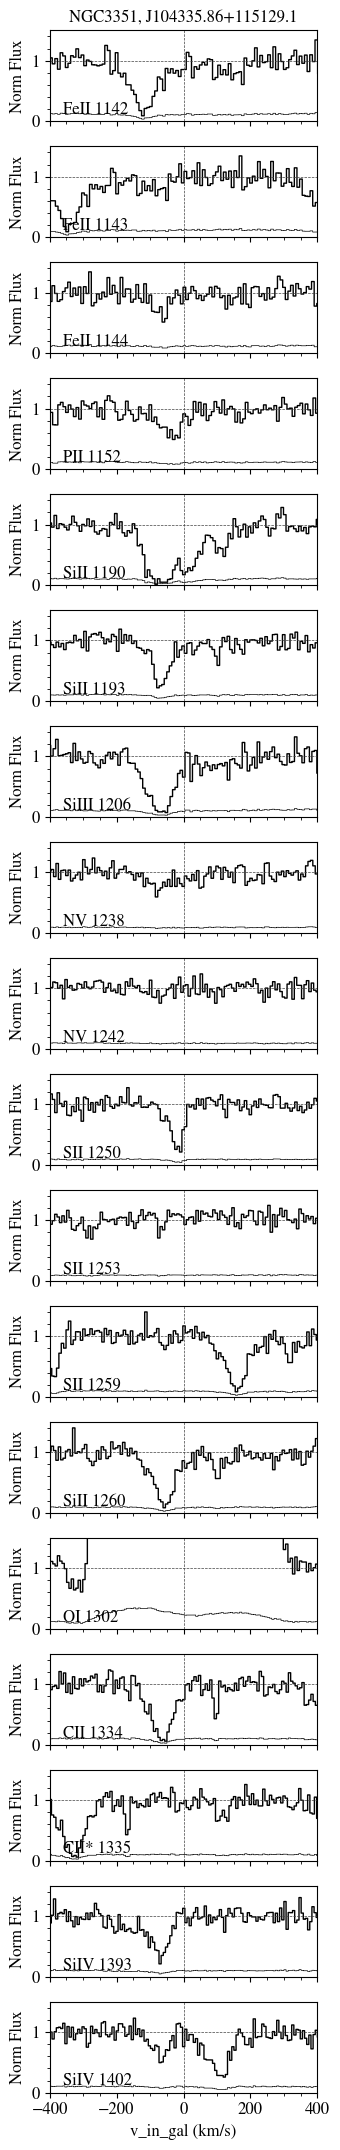

In [9]:
# we'll make a quick plot that shows all the available line data
figname = f'{savedir}/{gal_name}_{qso_name}_alllines_nofit.pdf'
print(figname)

from voigtfit_mod_cgm import plot_lines
plot_lines(gal_vhel, gal_name, qso_name, all_line_info, all_line_files, figname=figname, vmin=plt_vmin, vmax=plt_vmax)

# Decide which lines to fit for 

<span style="color: red;">Input needed: change lines_to_fit</span> <br>
Note: For CII* 1335, linetools call it "CII* 1335", while VoigtFit use "CIIa_1335.71" instead. So if you are using CII* 1335 line, make sure you are using the right ion and line name input for VoigtFit. 

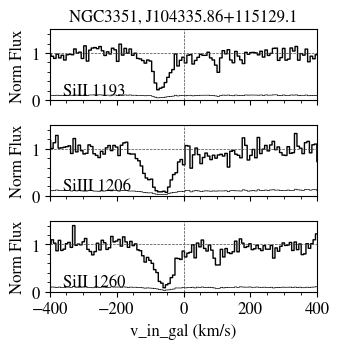

In [10]:
# here we decide to fit a few lines based on the plot above
# lines_to_fit = ['SiIV 1393', 'SiIV 1402']
lines_to_fit = ['SiII 1193', 'SiII 1260', 'SiIII 1206']
# lines_to_fit = ['FeII 1143', 'FeII 1144', 'PII 1152', 'SiII 1193', 'SiII 1260', 'SiIII 1206', 'NV 1238', 'NV 1242', 
#                    'CII 1334', 'SiIV 1393', 'SiIV 1402']

# we take a sub list of line info that we'd fit for 
lines_to_fit_info = all_line_info.query('(name in @lines_to_fit)')
plot_lines(gal_vhel, gal_name, qso_name, lines_to_fit_info, all_line_files, vmin=plt_vmin, vmax=plt_vmax)

Have an initial guesses on the voigt profile parameters based on AOD<br>
<span style="color: red;">Input needed: change vcomps based on figure above</span>

In [11]:
# based on the spectral above, let's do an initial guess on components based on aod results
# for each ion, you just need to specify a set of velocity ranges, 
# for example, no need to specify velocity ranges for SiIV 1393 and SiIV 1402 separately
vcomps = {'FeII': [[-150, 0]], 
          'PII': [[-150, 20]], 
          'SiIII': [[-180, -100], [-100, 40]], 
          'SiII': [[-180, -80], [-100, 20]], 
          'NV': [[-180, 20]], 
          'CII': [[-180, 20]], 
          'SiIV': [[-150, -80], [-80, 20]]
}

# this is a string that combines all ions to fit together, will be used to save data
ion_list = '-'.join(np.sort(list(vcomps.keys())))

from voigtfit_mod_cgm import estimate_init_guess_params
param_guess = estimate_init_guess_params(vcomps, lines_to_fit_info, all_line_files, gal_vhel)
param_guess

ion,vmin,vmax,z,vhel,v_in_gal,b,logN
str5,int64,int64,float64,float64,float64,float64,float64
SiII,-180,-80,0.002276,682.3,-94.7,4.9,12.99
SiII,-100,20,0.002393,717.3,-59.7,33.2,13.58
SiIII,-180,-100,0.002207,661.7,-115.3,10.0,12.74
SiIII,-100,40,0.0024,719.5,-57.5,36.7,13.46


<span style="color: red;">Input needed: change vcomps_exclude based on figure above</span>

In [12]:
# there may be contaminating components in some lines, in which case we'll exclude that chunk of data from the fit 
# here you need to specify which line may have contamination 
# each line has a nested list, you can put in multiple velocity ranges in a line if necessary
vcomps_exclude = {# 'SiIV 1393': [[-250, -140]], 
                  # 'SiIV 1402': [[30, 170]], 
                  #'SiII 1260': [[60, 180]], 
                  #'SiIII 1206': [[10, 150]], 
                  #'SiII 1193': [[70, 130]], 
                  #'CII 1334': [[50, 120]], 
                  #'SiII 1260': [[50, 180]]
                 }

In [13]:
# tie_ions = None

# this is a nested list, each list shows the ion that you'd like to tie together 
# if you want to tie multiple ions together, you can do something like: tie_ions = [['SiII', 'SiIII', 'SiIV']]
# if you want to tie two sets of ions separately, such as SiII, SiIII, SiIV together, and then PII and FeII together, 
# you can do: tie_ions = [['SiII', 'SiIII', 'SiIV'], ['PII', 'FeII']]

tie_ions_list = [['SiII', 'SiIII']]

# Note: the VoigtFit package allows to tie specific velocity components together, or tie v or logN or b
# but here we will only tie velocity togethers for all velocity components
# with the assumption that tied ions are co-spatial, thus share the same kinematics

# Initialize fitting with VoigtFit <br>
add spectral data, lines, and components, and velocity masks if needed <br>
<span style="color: red;">Input needed: change iterative_fit to true or false</span>

In [14]:
# Use False if this is the first time you are doing the fit
# Use True if if you want to use the previous round of fitting result do an interative fit
iterative_fit = False

if iterative_fit == False: 
    input_tb = param_guess.copy()  # first fit, parameters come from initial guess
    print('You are doing a first fit based on AOD initial guesses')
else: 
    input_tb = param_bestfit.copy() # iterative fit, parameters from the previous round of fitting
    print('You are doing an iterative fit based on the previous round of best fit parameters')

You are doing a first fit based on AOD initial guesses


Run the rest of the cells, no need to change anything

In [15]:
### initialize fitting, add data, and add lines
dataset = VoigtFit.DataSet(gal_z) # initial dataset by putting in the galaxy redshift 

## add velocity components based on initial guesses 
from voigtfit_mod_cgm import voigtfit_dataset_add_component
# note: if two components have centroid velocity more than close_comp_maxv apart
# they are not considered the same component, and won't be tied together. 
dataset = voigtfit_dataset_add_component(dataset, input_tb, tie_ions_list=tie_ions_list, close_comp_maxv=30)

0 SiIII -115.3 z0_SiII -94.7
1 SiIII -57.5 z1_SiII -59.7


lsf/cos_lsf_g130m_average_lp1-4_bin3_yz.txt
lsf/cos_lsf_g130m_average_lp1-4_bin3_yz.txt
lsf/cos_lsf_g130m_average_lp1-4_bin3_yz.txt


 [WARNING]  -  Check-lines is activated
 The following lines of included ions are also covered by the data:

     SiII_1190 :  f = 2.84e-01



  Fit is running... Please be patient.



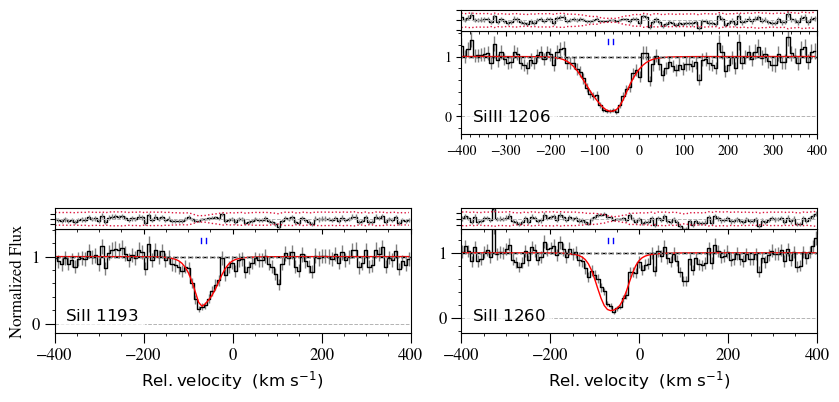

In [16]:
### add line and data
for line_name in lines_to_fit: 
    ## determine what lsf to use, note that this is binned data 
    from voigtfit_mod_cgm import determine_cos_lsf_file
    cos_lsf_file = determine_cos_lsf_file(line_name, data_nbin=data_nbin)
    print(cos_lsf_file)
    
    # read the corresponding data and estimate aod within the velocity range 
    line_datafile = all_line_files[line_name]
    line_spec = Table.read(line_datafile, format='ascii')

    # add data and line 
    dataset.add_data(line_spec['Wave'], line_spec['NormFlux'], cos_lsf_file, 
                     err=line_spec['NormErr'], normalized=True)
    # note that Linetools line format is "SiIV 1393", but 
    # VoigtFit package line format is "SiIV_1393"
    dataset.add_line(line_name.replace(' ', '_')) 

### add masks to exlude some velocity components in certain lines 
if len(vcomps_exclude) != 0:
    for key in vcomps_exclude: 
        for v_exc in vcomps_exclude[key]: 
            dataset.mask_range(key.replace(' ', '_'), v_exc[0], v_exc[1])

### also for all lines, we automatically mask anything beyond +/-400 km/s
for line_name in lines_to_fit: 
    dataset.mask_range(line_name.replace(' ', '_'), -100000, plt_vmin)
    dataset.mask_range(line_name.replace(' ', '_'), plt_vmax, +100000)

# Crucial step, prepare dataset, Run the fit:
dataset.prepare_dataset(verbose=False)
popt, chi2 = dataset.fit(verbose=False)
dataset.plot_fit()

In [17]:
display(input_tb)
#### save the best result into a txt file 
from voigtfit_mod_cgm import parse_output_to_astropy_table
tbname = f'{savename}_{ion_list}_vfit-param.txt'
param_bestfit = parse_output_to_astropy_table(dataset.best_fit, popt, gal_vhel, tbname=tbname)
display(param_bestfit)

ion,vmin,vmax,z,vhel,v_in_gal,b,logN
str5,int64,int64,float64,float64,float64,float64,float64
SiII,-180,-80,0.002276,682.3,-94.7,4.9,12.99
SiII,-100,20,0.002393,717.3,-59.7,33.2,13.58
SiIII,-180,-100,0.002207,661.7,-115.3,10.0,12.74
SiIII,-100,40,0.0024,719.5,-57.5,36.7,13.46


Saving best fit parameters to:  ./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_voigtfit_CII-FeII-NV-PII-SiII-SiIII-SiIV_vfit-param.txt


ion,z,z_e,vhel,vhel_e,v_in_gal,v_in_gal_e,b,b_e,flag,logN,logN_e
str5,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64
SiII,0.002353,1.6e-05,705.41,4.8,-71.6,4.8,4.05,10.97,N/A,13.5,2.2
SiII,0.002392,6e-06,717.1,1.8,-59.9,1.8,28.2,2.38,N/A,13.56,0.08
SiIII,0.002353,1.6e-05,705.41,4.8,-71.6,4.8,46.94,6.38,N/A,13.44,0.13
SiIII,0.002392,6e-06,717.1,1.8,-59.9,1.8,16.72,13.17,N/A,13.36,0.48


/Users/Yong/packages/linetools/linetools/linetools/analysis/voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/Yong/packages/linetools/linetools/linetools/analysis/voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')


Save voigt fit fluxes to:  ./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_voigtfit_SiII1193_vfit-flux.txt
Save voigt fit fluxes to:  ./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_voigtfit_SiII1260_vfit-flux.txt


/Users/Yong/packages/linetools/linetools/linetools/analysis/voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/Yong/packages/linetools/linetools/linetools/analysis/voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')


Save voigt fit fluxes to:  ./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_voigtfit_SiIII1206_vfit-flux.txt
Figure saved to:  ./data/J104335.86+115129.1/voigtfit/NGC3351_J104335.86+115129.1_voigtfit_CII-FeII-NV-PII-SiII-SiIII-SiIV_vfit.pdf


ion,z,z_e,vhel,vhel_e,v_in_gal,v_in_gal_e,b,b_e,flag,logN,logN_e
str5,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64
SiII,0.002353,1.6e-05,705.41,4.8,-71.6,4.8,4.05,10.97,=,13.5,2.2
SiII,0.002392,6e-06,717.1,1.8,-59.9,1.8,28.2,2.38,=,13.56,0.08
SiIII,0.002353,1.6e-05,705.41,4.8,-71.6,4.8,46.94,6.38,=,13.44,0.13
SiIII,0.002392,6e-06,717.1,1.8,-59.9,1.8,16.72,13.17,=,13.36,0.48


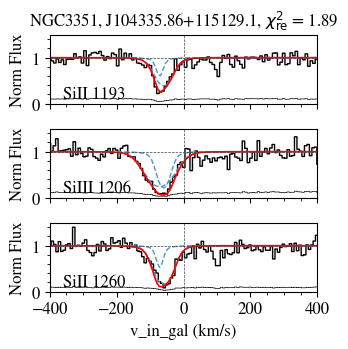

In [18]:
#### save model fluxes 
from voigtfit_mod_cgm import reproduce_voigt_model_fluxes
model_filenames = reproduce_voigt_model_fluxes(lines_to_fit_info, param_bestfit, all_line_files, savename, 
                                               gal_vhel, plt_vmin=plt_vmin, plt_vmax=plt_vmax, data_nbin=data_nbin,
                                               tbname=tbname)

#### plot the result
from voigtfit_mod_cgm import plot_lines
figname = f'{savename}_{ion_list}_vfit.pdf'
plot_lines(gal_vhel, gal_name, qso_name, lines_to_fit_info, all_line_files, figname=figname,
           model_filenames=model_filenames, vcomps_exclude=vcomps_exclude, vmin=plt_vmin, vmax=plt_vmax, 
           reduced_chi2=param_bestfit.meta['comments'][1].split('=')[1])

param_bestfit